In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils

In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [4]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### compute Checker Task accuracy for different sets of trials
Easy, Med, Hard are all in main grid, different positions relative to boundaries


In [6]:
center = 2.5

n_tasks = 4

dprime_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = l['is_main_grid']==1
       
        categ_actual = l['categ_task3']
        
        dist_from_center = l['dist_from_center'].round(3)
        un_dist = np.unique(dist_from_center[is_main_grid])
    
        is_hard = is_main_grid & (dist_from_center==un_dist[0])
        is_medium = is_main_grid & (dist_from_center==un_dist[1])
        is_easy = is_main_grid & (dist_from_center==un_dist[2])

        for ri in range(n_rois):

            ii = 2;
            # switching categs here so they match categs in labels .csv file
            categ_pred = 3 - dec_withintask['preds_all'][si][ri][ti][ii].astype(int)
            # print(np.mean(categ_actual==categ_pred))
            
            # all trials
            inds = is_main_grid
            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_allmaintrials[si,ri,ti,0] = d;
            a = np.mean(categ_pred[inds]==categ_actual[inds])
            acc_allmaintrials[si,ri,ti,0] = a;

            # easy trials
            inds = is_easy
            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_easytrials[si,ri,ti,0] = d;
            a = np.mean(categ_pred[inds]==categ_actual[inds])
            acc_easytrials[si,ri,ti,0] = a;

            # medium trials
            inds = is_medium
            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_medtrials[si,ri,ti,0] = d;
            a = np.mean(categ_pred[inds]==categ_actual[inds])
            acc_medtrials[si,ri,ti,0] = a;

            # hard trials 
            inds = is_hard
            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_hardtrials[si,ri,ti,0] = d;
            a = np.mean(categ_pred[inds]==categ_actual[inds])
            acc_hardtrials[si,ri,ti,0] = a;


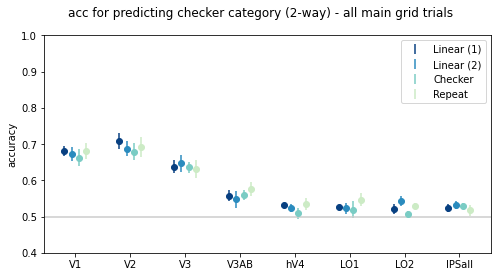

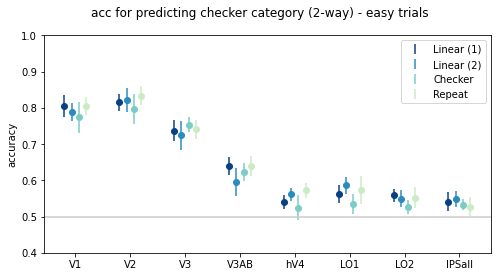

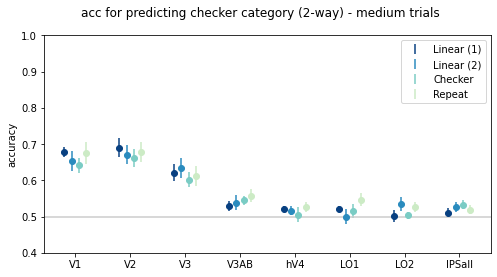

In [13]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

ii = 0;

for avals, name in zip([acc_allmaintrials, acc_easytrials, acc_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):

    plt.figure(figsize=(8,4))

    plt.axhline(1/2, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([0.4, 1.0])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('accuracy')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.suptitle('acc for predicting checker category (2-way) - %s'%name)


#### compute bootstrapped CIs for the correct/incorrect difference
on Checker Task hard trials only

In [10]:
n_coord_bins = 12;
coord_bin_edges = np.linspace(-0.801, 0.801, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
# bin_dist = (center-bin_centers).round(2)
bin_dist = bin_centers.round(2)


n_boot_iter = 1000;
# n_boot_iter = 2;

n_boot_samp = 100;

dprime_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 1, 2, n_boot_iter))
signedconf_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 1, 2, n_boot_iter))

for si, ss in enumerate(subjects):

    print(si)
    
    tt = 3;
    l = lab[ss][lab[ss]['task']==tt]
        
    pt_labs = np.array([l['ptx'], l['pty']]).T
    is_main_grid = np.array(l['is_main_grid']==1)

    categ_actual = np.array(l['categ_task3'])

    is_hard = ~is_main_grid

    coord_actual = np.array(l['dist_from_bound3'])
    coord_actual[categ_actual==1] = (-1)*coord_actual[categ_actual==1]

    # make rough bins that help equate stimulus distributions
    # across tasks when bootstrapping
    coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
    for cb in np.arange(n_coord_bins):
        binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
        coord_binned[binds] = cb
    assert(np.all(coord_binned[is_hard]>-1))


    # was the subject correct or incorrect?
    correct = np.array(l['subject_correct'])
   
    inds1 = np.where(is_hard & correct)[0]
    inds2 = np.where(is_hard & ~correct)[0]

    # now figure out which bins we can use and still have everything balanced in both correct/incorrect
    un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
    un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

    print(un1, counts1)
    print(un2, counts2)

    print(bin_dist[un1], bin_dist[un2])

    bins_balance = []
    for uu in np.union1d(un1, un2):
        d = bin_dist[uu]
        in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
        in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
        if in1 and in2:
            bins_balance += [uu]

    print(bin_dist[bins_balance])

    # checking that the bins we are using represent each category equally
    assert(np.mean(bin_dist[bins_balance]<0)==0.5)

    n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))
    
    
    # loop over correct/incorrect trials
    for ci, inds in enumerate([inds1, inds2]):

        nt = len(inds)

        for bi in range(n_boot_iter):

            # make a resampling order that represents each bin equally
            inds_resamp = []
            for bn in bins_balance:
                inds_bin = inds[coord_binned[inds]==bn]
                assert(len(inds_bin)>0)
                if bi==0:
                    print(len(inds_bin), n_samp_eachbin)
                inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
            inds_resamp = np.concatenate(inds_resamp, axis=0)

            # check that the set we created has half each category
            assert(np.mean(categ_actual[inds_resamp]==1)==0.5)

            # double check resample order
            assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
            counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
            assert(np.all(counts==n_samp_eachbin))

            # get predictions from each ROI, these trials
            for ri in range(n_rois):

                categ_pred = 3 - dec_withintask['preds_all'][si][ri][2][2].astype(int)
                # print(np.mean(categ_pred==categ_actual))
                
                prob = dec_withintask['probs_all'][si][ri][2][2]

                p_categ1 = prob[:,1]
                p_categ2 = prob[:,0]

                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]


                d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                dprime_hardtrials_sepcorrect_boot[si,ri,0,ci,bi] = d

                signedconf_hardtrials_sepcorrect_boot[si,ri,0,ci,bi] = np.mean(signedconf[inds_resamp])



0
[2 3 8 9] [38 20 31 42]
[2 3 8 9] [18 20  9 14]
[-0.47 -0.33  0.33  0.47] [-0.47 -0.33  0.33  0.47]
[-0.47 -0.33  0.33  0.47]
38 25
20 25
31 25
42 25
18 25
20 25
9 25
14 25
1
[2 3 4 7 8 9] [12 39  9  8 46 10]
[2 3 4 7 8 9] [ 4 25  7  8 18  6]
[-0.47 -0.33 -0.2   0.2   0.33  0.47] [-0.47 -0.33 -0.2   0.2   0.33  0.47]
[-0.47 -0.33 -0.2   0.2   0.33  0.47]
12 17
39 17
9 17
8 17
46 17
10 17
4 17
25 17
7 17
8 17
18 17
6 17
2
[ 1  2  3  8  9 10] [10 34  8 12 56 14]
[ 1  2  3  8  9 10] [ 6 30  8  4  8  2]
[-0.6  -0.47 -0.33  0.33  0.47  0.6 ] [-0.6  -0.47 -0.33  0.33  0.47  0.6 ]
[-0.6  -0.47 -0.33  0.33  0.47  0.6 ]
10 17
34 17
8 17
12 17
56 17
14 17
6 17
30 17
8 17
4 17
8 17
2 17
3
[2 3 4 7 8 9] [37 18  4  3 28 41]
[2 3 4 7 8 9] [19 14  4  5  4 15]
[-0.47 -0.33 -0.2   0.2   0.33  0.47] [-0.47 -0.33 -0.2   0.2   0.33  0.47]
[-0.47 -0.33 -0.2   0.2   0.33  0.47]
37 17
18 17
4 17
3 17
28 17
41 17
19 17
14 17
4 17
5 17
4 17
15 17
4
[3 8] [46 83]
[3 8] [50 13]
[-0.33  0.33] [-0.33  0.33]
[-0.

Text(0.5, 0.98, 'Hard trials in Checker Task: d-prime for discriminating checker categories, median +/- bootstrapped 95 CI')

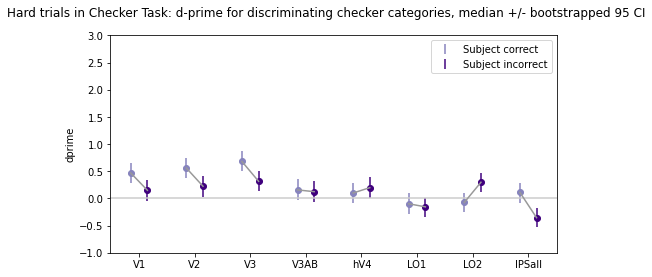

In [11]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(8,4))
   
colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

plt.axhline(0, color=[0.8, 0.8, 0.8])

lh = []

mtmp = []
for ci, boot_vals in enumerate([dprime_hardtrials_sepcorrect_boot[:,:,0,0,:], \
                                dprime_hardtrials_sepcorrect_boot[:,:,0,1,:]]):

    x_ticks = np.arange(n_rois) + x_jitter[ci]

    # average over subjects (within each bootstrapping iteration)
    boot_vals_avg = np.mean(boot_vals, axis=0)
    boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)

    # get percentiles of the bootstrapped distrib
    median_vals = boot_pct[1]
    mtmp.append(median_vals)
    lower_vals = median_vals - boot_pct[0]
    upper_vals = boot_pct[2] - median_vals

    plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
    h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
    lh.append(h)

for ri in range(n_rois):

    median_vals = [mtmp[0][ri], mtmp[1][ri]]
    plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

plt.ylim([-1, 3])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('dprime')

plt.legend(lh,['Subject correct','Subject incorrect'])

plt.suptitle('Hard trials in Checker Task: d-prime for discriminating checker categories, median +/- bootstrapped 95 CI')


Text(0.5, 0.98, 'Hard trials in Checker Task: classifier confidence, median +/- bootstrapped 95 CI')

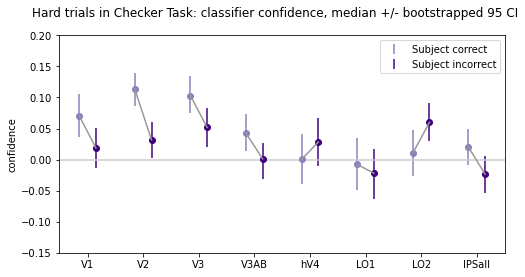

In [13]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(8,4))
   
colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

plt.axhline(0, color=[0.8, 0.8, 0.8])

lh = []

mtmp = []
for ci, boot_vals in enumerate([signedconf_hardtrials_sepcorrect_boot[:,:,0,0,:], \
                                signedconf_hardtrials_sepcorrect_boot[:,:,0,1,:]]):

    x_ticks = np.arange(n_rois) + x_jitter[ci]

    # average over subjects (within each bootstrapping iteration)
    boot_vals_avg = np.mean(boot_vals, axis=0)
    boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)

    # get percentiles of the bootstrapped distrib
    median_vals = boot_pct[1]
    mtmp.append(median_vals)
    lower_vals = median_vals - boot_pct[0]
    upper_vals = boot_pct[2] - median_vals

    plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
    h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
    lh.append(h)

for ri in range(n_rois):

    median_vals = [mtmp[0][ri], mtmp[1][ri]]
    plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

plt.ylim([-0.15, 0.20])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('confidence')

plt.legend(lh,['Subject correct','Subject incorrect'])

plt.suptitle('Hard trials in Checker Task: classifier confidence, median +/- bootstrapped 95 CI')
